# Application of Reinforcement learning for active learning

### In this experiment, we have implemented a custom OpenAI gym compatible environment to train a reinforcement learning agent to choose data points from available clusters to get optimal solution. The agent is trained using DQN algorithm implemented using Keras-rl as well as the custom implementation of DQN algorithm to compare the results. The model for learning is implemented using Keras library.

In [1]:
#Import all the required libraries
import gym
import numpy as np 
import matplotlib.pyplot as plt
#import gym_activerl #Gym implementation for continuous action space.
import gym_activerl1 #Gym implementation for discrete action space.
#from dqn import DQNAgent ##Use this import to use the custom DQN implementation

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam,SGD
#Imports from Keras-rl Library
from rl.agents.dqn import DQNAgent,NAFAgent 
from rl.policy import BoltzmannQPolicy,LinearAnnealedPolicy, EpsGreedyQPolicy,GreedyQPolicy
from rl.memory import SequentialMemory

Using TensorFlow backend.


### Create an instance of the environment

In [2]:
env = gym.make('activerl1-v0')

### To debug and to test whether the environment is properly set up, one can run following cells

In [3]:
print(env.observation_space.sample()) #Samples an observation from observation space
print(env.observation_space.shape)   #Displays the dimensions of the observation space
print(env.action_space.sample())    #Samples an action from the action space
print(env.action_space.n)           #Number of possible actions(For Discrete action space only)

[0.5488135 1.       ]
(2,)
835
1000


0.7487456378339987
(2,)
[0.5 1. ]
-1
False


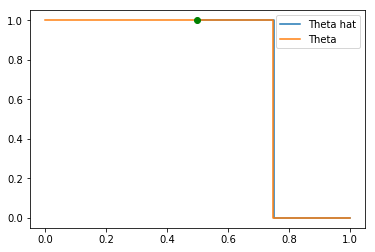

In [3]:
current_state = env.reset()                #Reset the environment 
print(env.theta)                           #Print the current theta of the environment(Which we need to predict)
print(current_state)                       #Get current state of the 
cur,reward,episode_over,_ = env.step(0.5)  #Take an action and choose 0.5
print(cur)                                 #Print the returned parameters.
print(reward)
print(episode_over)
print(info)
env.render()                               #visualize the action

0.10375436216600131
[0.705 1.   ]
-2
False
{}


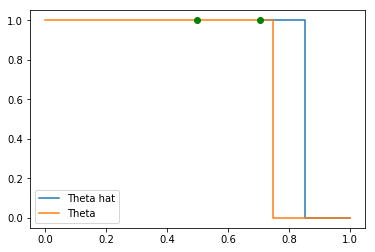

In [4]:
cur,reward,episode_over,info = env.step(0.705)
print(env.theta_n-env.theta)
print(cur)
print(reward)
print(episode_over)
print(info)
env.render()

### Define the model which we use to decide the action to be taken. If we are using the custom DQN model, then the model should have env.action_space.n number of actions in the output layer. Else if we are using Keras-rl model then it should be 1 as there is only 1 discrete action possible in this environment. The output has sigmoid activation as we need the action to be between 0 to 1. 

In [8]:
np.random.seed(123)
env.seed(123)
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))#
model.add(Dense(5))
model.add(Activation('sigmoid'))
model.add(Dense(20))
model.add(Activation('sigmoid'))
model.add(Dense(1000))              #This layer has only 1 node when it is used by keras-rl agent. Else it should be equal to nb_actions(1000)
model.add(Activation('sigmoid'))
model.compile(loss="mean_squared_error",optimizer=Adam(lr=0.001))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 15        
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                120       
_________________________________________________________________
activation_5 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              21000     
_________________________________________________________________
activation_6 (Activation)    (None, 1000)              0         
Total para

### Keras-RL implementation of DQN for discrete action space environment. The memory is the space allocated for the replay of RL agent. The policy used here is the Boltzmann Q policy. If one needs to use the Epsilon greedy Q policy just uncomment the statement. The weights of the trained RL agent is stored in h5 file.

In [9]:
nb_actions = env.action_space.n
memory = SequentialMemory(limit=5000, window_length=1)
policy = BoltzmannQPolicy()
#policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.,value_min=.1, value_test=.05,nb_steps=1000)
dqn = DQNAgent(model=model,nb_actions=nb_actions, memory=memory,nb_steps_warmup=50,train_interval=1,gamma=0.95,
               target_model_update=1, policy=policy)
dqn.compile(Adam(lr=0.0001), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False,nb_max_episode_steps=500,nb_max_start_steps=0,start_step_policy=None
        ,verbose=1)

# After training is done, we save the final weights.
dqn.save_weights('dqn_active_rl1_weights_1.h5f', overwrite=True)
#dqn.load_weights('dqn_active_rl1_weights_1.h5f')
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=False)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 68s 7ms/step - reward: -152.3830
51 episodes - episode_reward: -29646.902 [-119070.000, 7.000] - loss: 17095.300 - mean_absolute_error: 0.383 - mean_q: 0.537 - Theta: 0.415 - Predicted Theta: 0.417

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 68s 7ms/step - reward: -186.6723
37 episodes - episode_reward: -50488.297 [-123278.000, -47.000] - loss: 24285.438 - mean_absolute_error: 0.203 - mean_q: 0.162 - Theta: 0.528 - Predicted Theta: 0.527

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 68s 7ms/step - reward: -170.3443
45 episodes - episode_reward: -38066.178 [-122282.000, 3.000] - loss: 24655.873 - mean_absolute_error: 0.179 - mean_q: 0.021 - Theta: 0.459 - Predicted Theta: 0.461

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 68s 7ms/step - reward: -175.9688
39 episodes - e

KeyboardInterrupt: 

### Custom DQN agent implementation of DQN algorithm for discrete action space environment. It saves the weights when either the episode is over or the number of actions taken is 500.

In [4]:
trials  = 50000
trial_len = 500

dqn_agent = DQNAgent(env=env,model=model)
steps = []

for trial in range(int(trials/trial_len)):
    print("Current trial {}".format(trial))
    cur_state = env.reset().reshape(1,2)
    dqn_agent.forget()
    reward_list = list()
    for step in range(trial_len):
        action = dqn_agent.act(cur_state)
        new_state, reward, done, info = env.step(action)
        new_state = new_state.reshape(1,2)
        dqn_agent.remember(cur_state, action, reward, new_state, done)
        dqn_agent.replay()       # internally iterates default (prediction) model
        dqn_agent.target_train() # iterates target model
        reward_list.append(reward)
        cur_state = new_state
        if done:
            break
    if step >= trial_len:
        print("Failed to complete in trial {}".format(trial))
        print("Mean reward: ",np.mean(reward_list))
        print(info)
        if step % 10 == 0:
            dqn_agent.save_model("trial-{}.model".format(trial))
    elif done:
        print("Mean reward: ",np.mean(reward_list))
        print(info)
        print("Completed in {} trials".format(trial))
        dqn_agent.save_model("success.model")
    else:
        print("Mean reward: ",np.mean(reward_list))
        print(info)
        
        

Current trial 0
Mean reward:  -238.876
{'Theta': 0.4284709261868257, 'Predicted Theta': 0.42650002241134644}
Current trial 1
Mean reward:  -238.852
{'Theta': 0.7400139207215027, 'Predicted Theta': 0.6800000071525574}
Current trial 2
Mean reward:  -243.744
{'Theta': 0.563727084546804, 'Predicted Theta': 0.31850001215934753}
Current trial 3
Mean reward:  -247.556
{'Theta': 0.7966156112496982, 'Predicted Theta': 0}
Current trial 4
Mean reward:  -246.864
{'Theta': 0.46047009278625983, 'Predicted Theta': 0}
Current trial 5
Mean reward:  -245.744
{'Theta': 0.7142069923697506, 'Predicted Theta': 0}
Current trial 6


KeyboardInterrupt: 